# 6-1. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

https://github.com/e9t/nsmc

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

In [2]:
# !ln -s ~/data/*.txt ~/aiffel/Natural_Language_Processing/6_project/data

In [3]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [6]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/Natural_Language_Processing/6_project/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Natural_Language_Processing/6_project/data/ratings_test.txt')

train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [8]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


# 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [36]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 1. 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 2. 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 3. X_train 안에 있는 여러 개 리스트를 하나의 큰 리스트로 변환
    words = np.concatenate(X_train).tolist()
    
    # 4. 가장 자주 등장하는 9996개 단어만 추출
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    
    # 5. 앞 4자리 pad, bos, unk, unused 자리남겨놓고 키값 단어로 단어장 생성
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    
    # 6. word to index 딕셔너리 생성
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 7. 위에서 생성한 word_to_index을 iterable 리스트를 index로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    # 8. 토큰화된 텍스트 데이터를 word_to_index에 따라 정수(인덱스) 데이터로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [38]:
len(word_to_index)

10000

In [39]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [40]:
index_to_word[3]

'<UNUSED>'

In [41]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [45]:
# X_train[0] 데이터 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

#### 데이터셋 내 문장 길이 분포 및 maxlen 지정

In [46]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- maxlen = 41로 설정

#### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

- 마지막 입력에 무의미한 padding 정보가 최종 state 값에 영향을 끼치지 않도록 padding='pre' 로 설정한다.

In [48]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                      value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [50]:
# 앞부분에 pad 가 채워진 모습
X_train

array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    3],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8572],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

# 4) 모델 구성 및 validation set 구성 
### ** 5), 6) 학습과정과 결과시각화까지 포함
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

## A. 베이스라인 모델

#### 1. MLP 모델

In [72]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 32  # 워드 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
dense_4 (Dense)              (None, None, 64)          2112      
_________________________________________________________________
dense_5 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_6 (Dense)              (None, None, 8)           264       
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           9         
Total params: 324,465
Trainable params: 324,465
Non-trainable params: 0
_________________________________________________________________


#### 2. train, validation set split

In [73]:
# validation set : 앞부분 26,182 개
x_val = X_train[:26182]   
y_val = y_train[:26182]

# validation set을 제외한 나머지 100,000 개
partial_x_train = X_train[26182:]  
partial_y_train = y_train[26182:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(120000, 41)
(120000,)


#### 3. 모델 학습

In [74]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.6793 - accuracy: 0.5359 - val_loss: 0.6742 - val_accuracy: 0.5445
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.6733 - accuracy: 0.5449 - val_loss: 0.6738 - val_accuracy: 0.5450
Epoch 3/10
235/235 [==============================] - 1s 6ms/step - loss: 0.6729 - accuracy: 0.5428 - val_loss: 0.6738 - val_accuracy: 0.5391
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.6727 - accuracy: 0.5440 - val_loss: 0.6738 - val_accuracy: 0.5448
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6726 - accuracy: 0.5441 - val_loss: 0.6739 - val_accuracy: 0.5389
Epoch 6/10
235/235 [==============================] - 1s 6ms/step - loss: 0.6725 - accuracy: 0.5448 - val_loss: 0.6739 - val_accuracy: 0.5452
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6723 - accuracy: 0.5444 - val_loss: 0.6739 - val_accuracy: 0.5452
Epoch 

#### 4. Test set 평가 및 학습과정 시각화

In [75]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.6742 - accuracy: 0.5462
[0.6742445826530457, 0.5461692214012146]


In [76]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


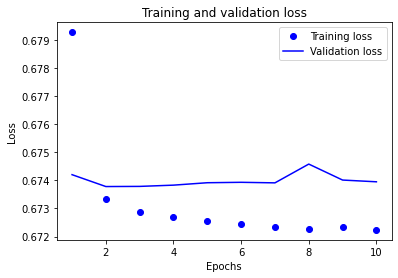

In [77]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

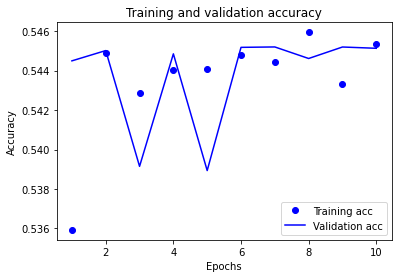

In [78]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 결과
: validation score 가 횡보하고, 예측 성능 accuracy는 0.5462로 나타났다.

## B. LSTM 모델

#### 1. LSTM 모델

In [79]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 32  # 워드 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


#### 2. 모델 학습

In [80]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 3s 7ms/step - loss: 0.4746 - accuracy: 0.7795 - val_loss: 0.3585 - val_accuracy: 0.8471
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8574 - val_loss: 0.3508 - val_accuracy: 0.8497
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3157 - accuracy: 0.8680 - val_loss: 0.3479 - val_accuracy: 0.8509
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3016 - accuracy: 0.8743 - val_loss: 0.3473 - val_accuracy: 0.8493
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2881 - accuracy: 0.8805 - val_loss: 0.3476 - val_accuracy: 0.8515
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2737 - accuracy: 0.8879 - val_loss: 0.3526 - val_accuracy: 0.8503
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2587 - accuracy: 0.8939 - val_loss: 0.3590 - val_accuracy: 0.8505
Epoch 

#### 3. Test set 평가 및 학습과정 시각화

In [81]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4086 - accuracy: 0.8434
[0.4086464047431946, 0.8434200882911682]


In [82]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


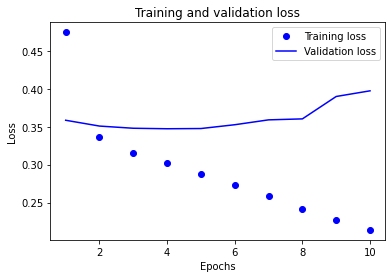

In [83]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

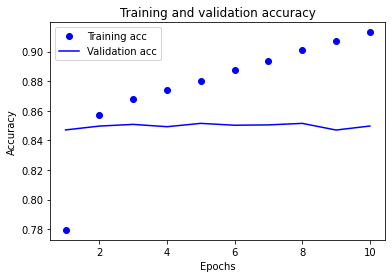

In [84]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 결과
1. validation 지표는 84% 부분에서 횡보한다.
2. 예측 성능은 0.8434로 나타났다.

## C. Conv1D 모델

#### 1. Conv1D 모델

In [93]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 32  # 워드 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

#### 2. 모델 학습

- 뚜렷한 오버피팅으로 인하여 early-stopping을 적용하였다.

In [94]:
from tensorflow.keras import callbacks

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

# early stopping 적용
check_point_cb = callbacks.ModelCheckpoint('nsmc_conv_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_accuracy',
                                  restore_best_weights=True)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb],
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 2s 5ms/step - loss: 0.4778 - accuracy: 0.7653 - val_loss: 0.3509 - val_accuracy: 0.8463
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3189 - accuracy: 0.8649 - val_loss: 0.3359 - val_accuracy: 0.8530
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2782 - accuracy: 0.8860 - val_loss: 0.3346 - val_accuracy: 0.8554
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2374 - accuracy: 0.9065 - val_loss: 0.3489 - val_accuracy: 0.8525
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1922 - accuracy: 0.9287 - val_loss: 0.3757 - val_accuracy: 0.8482
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1468 - accuracy: 0.9497 - val_loss: 0.4232 - val_accuracy: 0.8464


#### 3. Test set 평가 및 학습과정 시각화

In [95]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3429 - accuracy: 0.8520
[0.3428618907928467, 0.8520251512527466]


In [96]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


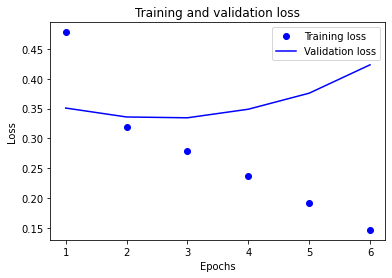

In [97]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

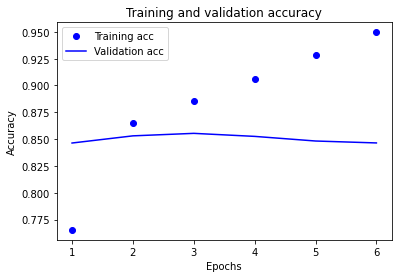

In [98]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 결과
1. 지속적인 overfitting 결과로 early stopping을 적용하였다.
2. 예측 성능은 0.8520 나타났다.

# 7) 학습된 Embedding 레이어 분석

### ** tf.keras.layers.Embedding() layer에 대한 조사
: 텐서플로우의 기본 임베딩 레이어는 defult로 Word2Vec 이나 GloVe 방법을 사용하는 것은 아니라고 한다. Trainable Word Embedding 이라는 방법을 사용한다고 하는데, 주어진 데이터 Sequance를 바탕으로 단어 간의 맥락에 따른 embedding을 자동적(automatically)으로 수행한다고 한다. 공식 문서에 정확히 어떻게 계산을 하는지 명시되지 않아서 명확히 알기 위해서는 조사가 더 필요하다(위 내용도 조사과정에서 알게 된 것이지 확실한 것은 아니다).

#### 1. 신경망의 첫번째 레이어(임베딩 레이어) 가중치 가져오기

In [100]:
# 1. 신경망의 첫번째 레이어 - 임베팅 레이어 가중치 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [103]:
import os

# 2. 학습한 Embedding Matrix Shape 에 맞게 txt 파일 format 지정
word2vec_file_path = os.getenv('HOME')+'/aiffel/Natural_Language_Processing/5_text_sentiment_analysis/data/word2vec_nsmc.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 3. 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#### 2. gensim 패키지를 통해 특정 단어의 similarity 찾아보기

In [104]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1. 특정 단어 임베딩 벡터 확인
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['올드보이']
vector

array([-0.06281798,  0.04186609,  0.04727322, -0.01814668, -0.02959412,
       -0.04611427, -0.04852955, -0.01310601,  0.02009903, -0.02920905,
        0.00928252,  0.0399061 , -0.00982128, -0.05880589,  0.04967264,
        0.00446268,  0.07342166, -0.0826338 , -0.04933527, -0.03213298,
       -0.11008549, -0.05309758, -0.04761687, -0.00319466, -0.00824252,
        0.00959915, -0.09084513, -0.03955551, -0.00790438, -0.03360588,
       -0.03885558,  0.1041568 ], dtype=float32)

In [105]:
# 2. 특정 단어 similarity 확인
word_vectors.similar_by_word("올드보이")

[('추격자', 0.8434109091758728),
 ('몰상식', 0.840806245803833),
 ('망쳐', 0.8310417532920837),
 ('토하', 0.8257088661193848),
 ('머니', 0.8241500854492188),
 ('더냐', 0.8186823129653931),
 ('꾹', 0.811855137348175),
 ('발단', 0.809951901435852),
 ('끌어내', 0.8089199066162109),
 ('임금', 0.8083780407905579)]

In [107]:
word_vectors.similar_by_word("액션")

[('일지라도', 0.7011461853981018),
 ('고독', 0.6921674013137817),
 ('종종', 0.6756765842437744),
 ('세끼', 0.6520416736602783),
 ('뚜', 0.6417894959449768),
 ('따질', 0.6376669406890869),
 ('과자', 0.6365544199943542),
 ('가물가물', 0.6310124397277832),
 ('브라질', 0.6196635961532593),
 ('멈출', 0.6134899258613586)]

In [106]:
word_vectors.similar_by_word("남자")

[('막힌', 0.6466558575630188),
 ('종교', 0.6154453754425049),
 ('덕화', 0.6031945943832397),
 ('다르', 0.6022520065307617),
 ('훔쳐', 0.5946638584136963),
 ('비씨', 0.5807972550392151),
 ('고급', 0.5764300227165222),
 ('토이', 0.573777973651886),
 ('써서', 0.5714559555053711),
 ('액티비티', 0.5705864429473877)]

### 결과 해석
: 단어장 크기가 1만 밖에 되지 않기 때문에 직관적으로 납득되는 similarity 결과가 나오지는 않는 것 같다.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 

참고 링크1 : https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models

참고 링크2 : https://radimrehurek.com/gensim/models/keyedvectors.html

In [109]:
# !ln -s ~/data/word2vec_ko.model ~/aiffel/Natural_Language_Processing/6_project/data
# !ln -s ~/data/word2vec_ko.model.wv.vectors.npy ~/aiffel/Natural_Language_Processing/6_project/data
# !ln -s ~/data/word2vec_ko.model.trainables.syn1neg.npy ~/aiffel/Natural_Language_Processing/6_project/data

In [112]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1. word2vec_ko.model 가져오기
word2vec_file_path = os.getenv('HOME')+'/aiffel/Natural_Language_Processing/6_project/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [121]:
# 특정 단어 벡터 확인
vector = word_vectors.wv['올드보이']
print(vector)
print(vector.shape)

[ 0.18901448  0.23930763 -0.01138354  0.42683017  0.20242402  0.17123362
  0.10146654 -0.5309428   0.26639494 -0.37546068 -0.0817335   0.15784363
 -0.31398302 -0.39122128  0.41635862 -0.44814846  0.05156617  0.00654991
 -0.41914752  0.09945242 -0.10991354 -0.01560397  0.02105762 -0.09780184
 -0.26582208 -0.3775913  -0.16773807 -0.06506912 -0.05164213 -0.02341526
 -0.6138084  -0.03348747  0.6609661  -0.21560201 -0.28838074  1.1208246
  0.1782352  -0.22217314 -0.31756273 -0.25315523  0.00173488 -0.426198
  0.0948153  -0.086848    0.25344634  0.09270598  0.03931575  0.17472243
  0.05885363 -0.59570146  0.2680588  -0.5826274  -0.14787991 -0.5030905
  0.00823046 -0.07371829  0.16872658 -0.04694016 -0.35794133 -0.02326294
 -0.5332243  -0.51591843 -0.35509    -0.42205688  0.02285642 -0.3257942
 -0.40564615  0.04625943  0.10697888  0.34467375  0.66846836  0.5256886
  0.20119981 -0.13078494  0.0061249  -0.1461806  -0.27436042 -0.05434515
  0.09471621 -0.29620144 -0.05945926 -0.38810763  0.16743

In [123]:
# 특정 단어 similarity 확인
word_vectors.wv.most_similar('올드보이', topn=10)

[('뉴문', 0.7747551798820496),
 ('석래명', 0.7744351029396057),
 ('후아유', 0.768900454044342),
 ('강제규', 0.7628114819526672),
 ('이누도', 0.7598366141319275),
 ('심야식당', 0.7590901851654053),
 ('말아톤', 0.7578907608985901),
 ('타짜', 0.757367730140686),
 ('안투라지', 0.7523742914199829),
 ('스카페이스', 0.7520132064819336)]

In [125]:
word_vectors.wv.most_similar('액션', topn=10)

[('코미디', 0.7429823279380798),
 ('스릴러', 0.7381718754768372),
 ('판타지', 0.6900153756141663),
 ('호러', 0.6892675757408142),
 ('SF', 0.6889281272888184),
 ('롤플레잉', 0.6625269055366516),
 ('영화', 0.6522793769836426),
 ('서스펜스', 0.6450006365776062),
 ('어드벤처', 0.6273845434188843),
 ('미스터리', 0.6250676512718201)]

In [124]:
word_vectors.wv.most_similar('남자', topn=10)

[('여자', 0.8692399263381958),
 ('엄마', 0.6886189579963684),
 ('남녀', 0.6824600100517273),
 ('친구', 0.672494649887085),
 ('소녀', 0.6496212482452393),
 ('어린아이', 0.6401294469833374),
 ('창녀', 0.6382424235343933),
 ('사나이', 0.6371455788612366),
 ('어른', 0.6340980529785156),
 ('아이', 0.6327983140945435)]

### Similarity 결과 비교
- transferred embedding 이전 similarity 결과

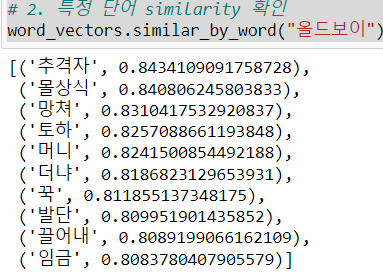

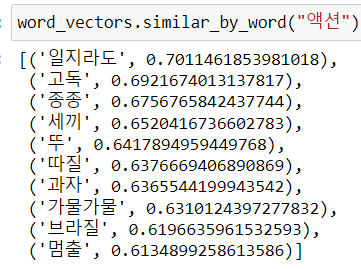

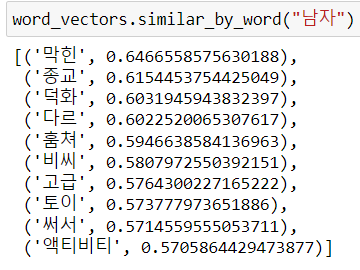

1. 이전 nsmc 임베딩의 similarity에서 '올드보이,' '액션,' '남자' 키워드는 위 그림과 같이 유사성을 연결하기 어려운 단어가 많이 포함되어 있었다.

2. 반면에, transferred embedding similarity에서 '올드보이,' '액션' 키워드는 구체적인 영화제목, 영화 장르와 같이 의미적으로 유사한 결과를 확인할 수 있었다. 직관적으로 의미의 유사도를 이해할 수 있다. '남자' 키워드는 반대 성별, 나이에 따른 분류와 같은 의미를 가진 단어가 나타났다.

3. 이는 영화리뷰에 국한된 임베딩 결과보다 transferred embedding space에 맵핑된 정보가 다양하고, dimension 또한 깊이 있기 때문에 직관적으로 납득할 수 있는 의미론적 공간을 형성한 것으로 보인다.

# pre-trained Embedding Model을 활용한 분류 테스크 수행

In [131]:
len(word_vectors.wv)

302960

pre-trained embedding model (word_vectors.wv) 에서 내게 주어진 단어장에 해당하는 단어의 embedded vector 정보를 가져와 embedding_matrix 에 저장한다.

In [132]:
vocab_size = 10000    # 나의 어휘 사전의 크기
word_vector_dim = 100  # 위에서 pre-trained embedding vector의 dimension이 100임을 확인하였다.
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors.wv 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [134]:
embedding_matrix.shape

(10000, 100)

가져온 embedding_matrix 임베팅 벡터 정보를 학습에 사용하는 임베팅 레이어의 초기값으로 사용한다.

In [158]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(64, return_sequences=True))   
model.add(tf.keras.layers.Dropout(0.5))   
model.add(tf.keras.layers.LSTM(32)) 
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 41, 64)            42240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 41, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [159]:
from tensorflow.keras import callbacks

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

# early stopping 적용
check_point_cb = callbacks.ModelCheckpoint('nsmc_trasferred_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5, monitor='val_accuracy',
                                  restore_best_weights=True)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 5s 13ms/step - loss: 0.5420 - accuracy: 0.7218 - val_loss: 0.4132 - val_accuracy: 0.8135
Epoch 2/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3952 - accuracy: 0.8260 - val_loss: 0.3646 - val_accuracy: 0.8392
Epoch 3/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3482 - accuracy: 0.8497 - val_loss: 0.3375 - val_accuracy: 0.8526
Epoch 4/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3193 - accuracy: 0.8648 - val_loss: 0.3263 - val_accuracy: 0.8596
Epoch 5/20
235/235 [==============================] - 2s 10ms/step - loss: 0.3017 - accuracy: 0.8733 - val_loss: 0.3229 - val_accuracy: 0.8636
Epoch 6/20
235/235 [==============================] - 2s 10ms/step - loss: 0.2835 - accuracy: 0.8832 - val_loss: 0.3211 - val_accuracy: 0.8635
Epoch 7/20
235/235 [==============================] - 2s 10ms/step - loss: 0.2699 - accuracy: 0.8891 - val_loss: 0.3253 - val_accuracy: 0.8643

#### 3. Test set 평가 및 학습과정 시각화

In [160]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.3840 - accuracy: 0.8601
[0.3840155303478241, 0.8601419925689697]


In [161]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


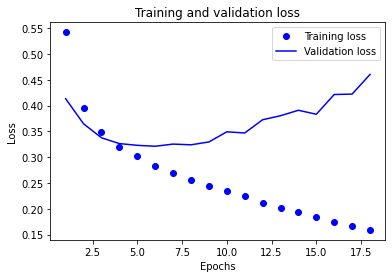

In [162]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

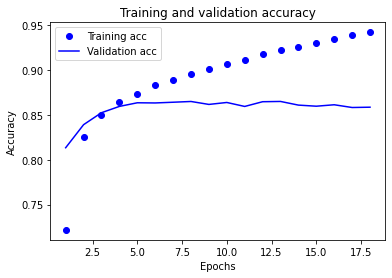

In [163]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Classification Report 및 Heat Map 시각화

In [169]:
from sklearn.metrics import classification_report

# 1. 예측 확률값
pred = model.predict(X_test)

# 2. 예측확률을 0 또는 1로 변환
threshold = 0.5
pred_values = np.where(pred > threshold, 1, 0)
pred_values

# 4. 분류 보고서 확인
print(classification_report(y_test, pred_values))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     24446
           1       0.87      0.85      0.86     24711

    accuracy                           0.86     49157
   macro avg       0.86      0.86      0.86     49157
weighted avg       0.86      0.86      0.86     49157



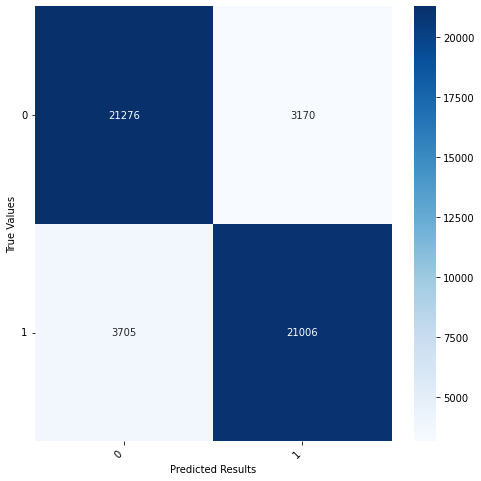

In [174]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 8))
cm2 = confusion_matrix(y_test, pred_values)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Results')
plt.ylabel('True Values')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### 결과
1. 주어진 태스크에서 pre-trained embedding model을 사용한다고 하여 더 나은 성능 향상은 없었다.
2. 다만 LSTM layer를 추가하고 units 수를 증가시켰을 때 약 2~3%의 성능 향상이 있었다.
3. 최종 성능은 accuracy 0.8601, f1-score 0.86 로 나타났다.

# 회고
- 배운 점
1. 텍스트 데이터를 정수로 인코딩하는 'word to index' 방법을 실제 구현할 수 있었다.
2. 정수로 인코딩한 텍스트 데이터를 embedding layer을 통해 적절한 dimension을 가진 vector로 변환할 수 있었다. 이 vectors는 텍스트 데이터의 문맥에 의해 결정되는 의미론적 공간에 문장 데이터를 매핑한 것이다(self-supervised learning).
3. 텍스트 데이터를 가지고 자연어 태스크를 수행할 때 MLP 모델보다 RNN 계열의 LSTM 모델이 월등한 성능을 나타내는 것을 확인하였다.
4. 1d convolution 을 통해서 텍스트를 학습했을 때도 LSTM과 비슷한 성능을 나타냈다.
5. Pre-trained embedding model을 불러와서 transfer learning을 수행할 수 있었다.
6. 이번 태스크에서는 transfer learning으로 인한 큰 성능향상은 없었지만, LSTM layer와 units을 추가했을 때 2~3%의 성능향상이 있었다.
7. 확실한 답을 얻지 못했지만 텐서플로우의 Embedding layer에 대한 조사를 했다. 어떤 임베딩 방법이 defult로 적용되는지 궁금해서 찾아보았는데, trainable word embedding 이라는 방법이 적용된다고 한다. 의외였던 것은 Word2Vec이나 GloVe가 기본적으로 적용되지는 않는다는 것이었다.

- 보완할 점
1. 직접 코딩을 수행하면서 embedding 과정과 개념을 아직 완전히 이해하지 못한 것을 느꼈다. 코드에 오류가 날 때마다 밑바닥에서부터 이해과정을 복기하면서 결과를 완성시켜갔다.
2. 모델 성능 개선 과정에서 LearningRateScheduler 방법이 생각났다. 잊어버린 것이 많아 이해를 복구한 뒤 여러 개선 방법을 시도할 수 있을 것 같다.
3. 위에서 언급한 텐서플로우의 Embedding layer에서 이루어지는 구체적인 계산 방법은 추가적인 조사를 통해 더 알아봐야 할 것 같다. 생각보다 이 부분에 대해 구체적이게 명시한 자료가 없었다.